# Plan-and-Execute

This notebook shows how to create a "plan-and-execute" style agent. This is heavily inspired by the [Plan-and-Solve](https://arxiv.org/abs/2305.04091) paper as well as the [Baby-AGI](https://github.com/yoheinakajima/babyagi) project.

The core idea is to first come up with a multi-step plan, and then go through that plan one item at a time.
After accomplishing a particular task, you can then revisit the plan and modify as appropriate.


The general computational graph looks like the following:


![plan-and-execute diagram](../img/plan-and-execute.png)


This compares to a typical [ReAct](https://arxiv.org/abs/2210.03629) style agent where you think one step at a time.
The advantages of this "plan-and-execute" style agent are:

1. Explicit long term planning (which even really strong LLMs can struggle with)
2. Ability to use smaller/weaker models for the execution step, only using larger/better models for the planning step


The following walkthrough demonstrates how to do so in LangGraph. The resulting agent will leave a trace like the following example: ([link](https://smith.langchain.com/public/d46e24d3-dda6-44d5-9550-b618fca4e0d4/r)).

## Setup

First, we need to install the packages required.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain_groq tavily-python

Next, we need to set API keys for Groq (the LLM we will use) and Tavily (the search tool we will use)

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GROQ_API_KEY")
_set_env("TAVILY_API_KEY")

Optionally, we can set API key for LangSmith tracing, which will give us best-in-class observability.

In [5]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Plan-and-execute"

## Define Tools

We will first define the tools we want to use. For this simple example, we will use a built-in search tool via Tavily. However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/v0.2/docs/how_to/custom_tools) on how to do that.

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

## Define our Execution Agent

Now we will create the execution agent we want to use to execute tasks. 
Note that for this example, we will be using the same execution agent for each task, but this doesn't HAVE to be the case.

In [6]:
from langchain import hub
from langchain_groq import ChatGroq

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatGroq(model_name="llama-3.1-70b-versatile", temperature=0.0)
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

C:\Users\samih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


C:\Users\samih\AppData\Local\Temp\ipykernel_1744\215378746.py:12: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)


In [7]:
agent_executor.invoke({"messages": [("user", "who is the winner of the us open")]})

{'messages': [HumanMessage(content='who is the winner of the us open', id='f75cd32f-eedb-4e67-b5a6-0d37fe3d05ba'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4k92', 'function': {'arguments': '{"query":"US Open winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 956, 'total_tokens': 1035, 'completion_time': 0.316, 'prompt_time': 0.200958608, 'queue_time': None, 'total_time': 0.516958608}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b3ae7e594e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1304b932-5d55-4dbc-9e4f-54b6c00803ca-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US Open winner'}, 'id': 'call_4k92', 'type': 'tool_call'}], usage_metadata={'input_tokens': 956, 'output_tokens': 79, 'total_tokens': 1035}),
  ToolMessage(content='[{"url": "https://www.cnn.com/2024/06/16/sport/bryson-dechambeau-us-o

## Define the State

Let's now start by defining the state the track for this agent.

First, we will need to track the current plan. Let's represent that as a list of strings.

Next, we should track previously executed steps. Let's represent that as a list of tuples (these tuples will contain the step and then the result)

Finally, we need to have some state to represent the final response as well as the original input.

In [8]:
import operator
from typing import Annotated, List, Tuple, TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

## Planning Step

Let's now think about creating the planning step. This will use function calling to create a plan.

In [9]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [10]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatGroq(model_name="llama-3.1-70b-versatile", temperature=0.0).with_structured_output(Plan)

In [12]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Find the current Australia Open winner', 'Find the hometown of the winner'])

## Re-Plan Step

Now, let's create a step that re-does the plan based on the result of the previous step.

In [13]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatGroq(model_name="llama-3.1-70b-versatile", temperature=0.0).with_structured_output(Act)

## Create the Graph

We can now create the graph!

In [14]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": (task, agent_response["messages"][-1].content),
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [15]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

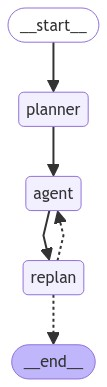

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [18]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Find the winner of the 2024 Australia Open', 'Find the hometown of the winner']}
{'past_steps': ('Find the winner of the 2024 Australia Open', 'The winner of the 2024 Australian Open is Jannik Sinner.')}


TypeError: can only concatenate list (not "tuple") to list

## Conclusion

Congrats on making a plan-and-execute agent! One known limitations of the above design is that each task is still executed in sequence, meaning embarrassingly parallel operations all add to the total execution time. You could improve on this by having each task represented as a DAG (similar to LLMCompiler), rather than a regular list.